# Convolutional networks
This file shows how to programm and setup a convolutional neural network using Tensorflow.
Steps to do:
	- download and import data
    - preprocess data (structure data into training, validation, test set etc)
    - create mini-batches of data for training
    - setup or import a neural network model (tf.Graph)
    - define loss function
    - train neural network
    - evaluate neural network
    - provide an inference function for predicting labels of test data set (unknown data)
    - visualize neural network data with tensorflow and here in jupyter notebook

In [1]:
"""
Predict albedo and shading layer of an input image.
"""

import os
import sys
sys.path.append('./util')
import pandas as pd
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import input_queues as iq
import plot_helpers as plt_help


__author__ = "Udo Dehm"
__copyright__ = "Copyright 2017"
__credits__ = ["Udo Dehm"]
__license__ = ""
__version__ = "0.1"
__maintainer__ = "Udo Dehm"
__email__ = "udo.dehm@mailbox.org"
__status__ = "Development"

__all__ = ['predict']

# make only 'gpu:0' visible, so that only one gpu is used not both, see also
# https://github.com/tensorflow/tensorflow/issues/5066
# https://github.com/tensorflow/tensorflow/issues/3644#issuecomment-237631171
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

def predict(image, path_inference_graph, checkpoint_path, image_shape,
            nodes_name_dict, norm=False, plot_inference_graph=False):
    """
    :param image:
    :type image:
    :param path_inference_graph: path to inference graph (graph without 
        'training' ops)
    :type path_inference_graph: str
    :param checkpoint_path: path to model parameters (checkpoint files
        e.g. 'logs/2/tfmodel-5')
    :type checkpoint_path: str
    :param image_shape: Shape of images that should be used for training 
        (shape of cnn input tensor)
    :type image_shape: list with len(image_shape)==3
    :param nodes_name_dict: dictionary that contains name of input, albedo and 
        shading output in form {'input': '', 
                                'output_albedo': '',
                                'output_shading': ''}
    :type nodes_name_dict: dict
    :param norm: flag, if True image pixels are scaled to range [0, 1]
        (default: False)
    :type norm: boolean
    :param plot_inference_graph: flag, True if inference graph should be 
        plotted (default: False).
    :type plot_inference_graph: boolean

    :return: ground-truth image, ground-truth albedo layer, ground-truth
        shading layer, prediction albedo layer, prediction shading layer
    """
    if isinstance(image, (pd.DataFrame, pd.Series, list, tuple)):
        image = pd.DataFrame(image)
    elif isinstance(image, str):
        image = pd.DataFrame([image])
    else:
        raise TypeError('Not a valid type: image must be one of the ' + 
                        'following types: (pd.DataFrame, pd.Series, ' + 
                        'list, tuple, str).')
     
    # import meta (inference) graph:
    meta_graph = tf.train.import_meta_graph(path_inference_graph,
                                            clear_devices=True)
    # save default graph in variable:
    graph = tf.get_default_graph()
    if plot_inference_graph:
        # plot imported inference graph:
        plt_help.show_graph(graph.as_graph_def())


    ############################################################################
    ############################################################################
    # defining input/output nodes:

    # lets get the input
    x = graph.get_tensor_by_name(name=nodes_name_dict['input'])
    print('Input shape: {}.'.format(x.shape))

    # bool variable that indicates if we are in training mode (training=True) or
    # valid/test mode (training=False) this indicator is important if dropout 
    # or/and batch normalization is used.
    try:
        # try importing training node (is needed for models that use batch 
        # normalization etc.)
        training = graph.get_tensor_by_name(name='is_training:0')
    except KeyError:
        # elsewise just define a placeholder wich is used as dummy variable
        # and won't be used later:
        training = tf.placeholder(dtype=tf.bool, name='is_training')

    # get graph output nodes:
    y_albedo_pred = graph.get_tensor_by_name(name=nodes_name_dict['output_albedo'])
    y_shading_pred = graph.get_tensor_by_name(name=nodes_name_dict['output_shading'])
    # y_albedo_pred = tf.clip_by_value(t=y_albedo, clip_value_min=0, 
    #                                  clip_value_max=1, 
    #                                  name='0_1_clipping_albedo')
    # y_shading_pred = tf.clip_by_value(t=y_shading, clip_value_min=0,
    #                                   clip_value_max=1, 
    #                                   name='0_1_clipping_shading')

    ############################################################################
    ############################################################################
    # making prediction:

    with tf.Session() as sess:
        # Restore variables from disk.
        meta_graph.restore(sess, checkpoint_path)

        # import one image:
        images = iq.next_batch(deq=image,
                               output_shape=image_shape,
                               is_scale=False,
                               is_flip=False,
                               is_rotated=False,
                               norm=norm)

        feed_dict = {x: images[0], training: False}
        pred_alb, pred_shad = sess.run([y_albedo_pred, y_shading_pred],
                                       feed_dict=feed_dict)
    
    return images, pred_alb, pred_shad

In [2]:
m_height = 13  # multiplicate of image height size -> network is designed so 
    # that it can take images with shape of multiples of m
m_width = m_height  # multiplicate of image width size -> network 
    # is designed so that it can take images with shape of multiples of m


# # narihira2015:
# nodes_name_dict = {'input': 'input:0',
#                    'output_albedo': 'deconv_s2out_albedo/BiasAdd:0',
#                    'output_shading': 'deconv_s2out_shading/BiasAdd:0'}

# params = {'path_inference_graph': 'models/narihira2015/tfmodel_inference.meta',
#           'checkpoint_path': None, # e.g. 'logs/2/tfmodel-5' or None
#           'image_shape': [32 * m_height, 32 * m_width, 3],
#           'nodes_name_dict': nodes_name_dict,
#           'norm': True,
#           'plot_inference_graph': False}


# slim_vgg16_narihira2015:
nodes_name_dict = {'input': 'input:0',
                   'output_albedo': 'scale2/deconv6_s2_albedo/BiasAdd:0',
                   'output_shading': 'scale2/deconv6_s2_shading/BiasAdd:0'}
# download checkpoint files:
params = {'path_inference_graph': 'models/slim/graphs/vgg16_narihira2015/tfmodel_inference.meta', # e.g. 'logs/2/tfmodel-5' or None
          'checkpoint_path': 'logs/slim_vgg16_narihira2015/2/tfmodel-2100',
          'image_shape': [32 * m_height, 32 * m_width, 3],
          'nodes_name_dict': nodes_name_dict,
          'norm': True,
          'plot_inference_graph': False}

In [3]:
# testing data set:
data_dir = '/usr/udo/data/'
file = 'data_sintel_shading_train.csv'
df_test = pd.read_csv(data_dir + file, sep=',', header=None,
                      names=['img', 'alb', 'shad', 'invalid'])
# compolete image paths:
df_test = data_dir + df_test


# img_paths = pd.DataFrame({'img': ['data1/mpi-sintel-shading/clean_noshadingtextures/market_2/frame_0050.png'],
#  'alb': ['data1/mpi-sintel-shading/albedo_noshadingtextures/market_2/frame_0050.png'],
#  'shad': ['data1/mpi-sintel-shading/shading/market_2/out_0386.png']})

In [11]:
image = df_test.loc[[0], ['img', 'alb', 'shad']]

In [12]:
images, pred_alb, pred_shad = predict(image=image, **params)

Input shape: (?, ?, ?, 3).
INFO:tensorflow:Restoring parameters from logs/slim_vgg16_narihira2015/2/tfmodel-2100


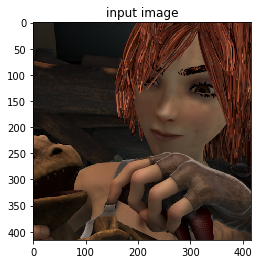

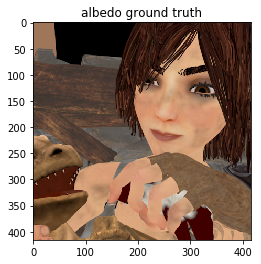

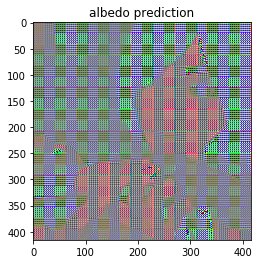

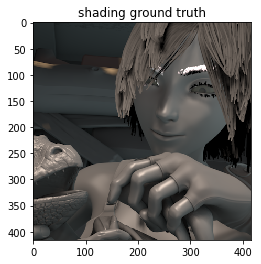

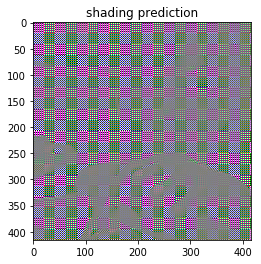

In [32]:
################################################################################

#print(f'path to (raw) image: {path_te}')
plt_help.plot_images(images=[images[0].reshape(params['image_shape']), 
                             images[1].reshape(params['image_shape']), 
                             pred_alb.reshape(params['image_shape']), 
                             images[2].reshape(params['image_shape']), 
                             pred_shad.reshape(params['image_shape'])],
                     titles=['input image', 
                             'albedo ground truth', 
                             'albedo prediction', 
                             'shading ground truth', 
                             'shading prediction'])

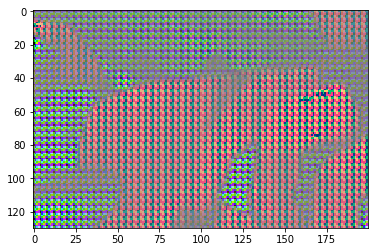

In [8]:
img_inspect = pred_alb.reshape(params['image_shape'])
plt.imshow(img_inspect[220:200+150,100:100+200,:])

In [17]:
# !tensorboard --logdir ./logs/camp/2